* Here I have implemented two solutions 
  + "optimizer out of the box" (https://github.com/bayesian-optimization)
  + "optimizer from scratch"
* The code, results and figures are presented in the corresponding sections.
* Note that the presented solution is only a simple but working solution, it does not provide `the best optimal learning rate`, since it uses one learning epoch for the ResNet model.

### Task description

Objective: Find the optimal learning rate of a deep neural network for CV
Optimizer: 
* Implement Bayesian Optimization (BO) as a global optimization approach
 + use a Gaussian Process as a predictive model (you can use any existing GP library)
 + implement expected improvement (EI) as an acquisition function
 + use an optimization budget of 10 function evaluations

* For the deep neural network, please follow the specifications below:
 + A rather small ResNet (details can be chosen by you, but you should implement it on your own)
 + Optimizer: SGD 
 + Deep learning framework: PyTorch or JAX
 + Dataset: Fashion-MNIST

* Plotting:
 + Starting with the second iteration of Bayesian Optimization, plot all observations, the posterior mean, the uncertainty estimate, and the acquisition function after each iteration.
 + See here for an exemplary plot (on a different task): https://towardsdatascience.com/shallow-understanding-on-bayesian-optimization-324b6c1f7083

* Programming language: Python; minimal coding standards:
 + PEP8 
 + Doc-Strings
 + README with instructions how to run it

### Setup

In [1]:
%%capture
!pip install bayesian-optimization

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

import random
import numpy as np
import scipy.stats as sps
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

torch.__version__

'2.0.1+cu118'

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Ploting utils

In [4]:
def plot_gp(optimizer, x=None, y=None, utility_function=None):
    def posterior(optimizer, x_obs, y_obs, grid):
        optimizer._gp.fit(x_obs, y_obs)
        mu, sigma = optimizer._gp.predict(grid, return_std=True)
        return mu, sigma

    fig = plt.figure(figsize=(8, 5))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian process and acquisition function after {} steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    if x == None:
      x = np.linspace(1e-9, 1e-2, 10000).reshape(-1, 1)
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    
    if y != None:
      axis.plot(x, y, linewidth=3, label='Target')
    
    axis.plot(x, mu, '--', color='k', label='Prediction')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((1e-9, 1e-2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    if utility_function == None:
      utility_function = UtilityFunction(kind="ei", kappa=2.5)
    utility = utility_function.utility(x, optimizer._gp, 0)

    acq.plot(x, utility, label='Acquisition function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Best guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((1e-9, 1e-2))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

def plot_gp_(gp, x_obs, y_obs, utility_function=None):
    def posterior(gp, x_obs, y_obs, grid):
        gp.fit(x_obs, y_obs)
        mu, sigma = gp.predict(grid, return_std=True)
        return mu, sigma

    fig = plt.figure(figsize=(8, 5))
    fig.suptitle(
        'Gaussian process and acquisition function after {} steps'.format(len(y_obs)),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x = np.linspace(1e-9, 1e-2, 10000).reshape(-1, 1)
    mu, sigma = posterior(gp, x_obs, y_obs, x)
    
    axis.plot(x, mu, '--', color='k', label='Prediction')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((1e-9, 1e-2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    if utility_function == None:
      utility_function = UtilityFunction(kind="ei", kappa=2.5)
      utility = utility_function.utility(x, gp, 0)
    else:
      utility = utility_function(x)
    acq.plot(x, utility, label='Acquisition function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Best guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((1e-9, 1e-2))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

### ResNet init

In [5]:
%%capture
# train
train_FMNIST = FashionMNIST(root = "./", 
                            train = True, 
                            transform = ToTensor(), 
                            download = True)

train_dataloader = DataLoader(train_FMNIST, batch_size=30, shuffle=True, drop_last=False)

# test
test_FMNIST = FashionMNIST(root = "./", 
                           train = False, 
                           transform = ToTensor(), 
                           download = True)

test_dataloader = DataLoader(test_FMNIST, batch_size=30, shuffle=True, drop_last=False)

In [6]:
class MyBlock(nn.Module):
    expansion = 4
    def __init__(self, in_channels, inter_channels, stride):
        super(MyBlock, self).__init__()
        conv1 = []
        conv1.append(nn.Conv2d(in_channels, inter_channels, 1, stride, 0))
        conv1.append(nn.BatchNorm2d(inter_channels))
        conv1.append(nn.ReLU())
        conv1.append(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1))
        conv1.append(nn.BatchNorm2d(inter_channels))
        conv1.append(nn.ReLU())
        conv1.append(nn.Conv2d(inter_channels, inter_channels * 2, 1, 1, 0))
        conv1.append(nn.BatchNorm2d(inter_channels * 2))
        self.conv1 = nn.Sequential(*conv1)

        conv2 = []
        conv2.append(nn.Conv2d(in_channels, inter_channels, 1, stride, 0))
        conv2.append(nn.BatchNorm2d(inter_channels))
        conv2.append(nn.ReLU())
        conv2.append(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1))
        conv2.append(nn.BatchNorm2d(inter_channels))
        conv2.append(nn.ReLU())
        conv2.append(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1))
        conv2.append(nn.BatchNorm2d(inter_channels))
        conv2.append(nn.ReLU())
        conv2.append(nn.Conv2d(inter_channels, inter_channels * 2, 1, 1, 0))
        conv2.append(nn.BatchNorm2d(inter_channels * 2))
        self.conv2 = nn.Sequential(*conv2)
        
        short = []
        if stride != 1 or in_channels != inter_channels * self.expansion:
            short.append(nn.Conv2d(in_channels, inter_channels * self.expansion, 1, stride, 0))
            short.append(nn.BatchNorm2d(inter_channels * self.expansion))
        self.short = nn.Sequential(*short)
        self.relu = nn.ReLU()

    def forward(self, x): 
        out = torch.cat([self.conv1(x), self.conv2(x)], 1)
        x = self.short(x)
        out = self.relu(out + x)
        return out

class ResNet(nn.Module):
    def __init__(self, block=MyBlock, block_list=[3, 4, 6, 3]):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, 3, 1, 1), 
                                   nn.BatchNorm2d(64), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(3, 2, 1))
        
        self.block1 = self.make_layers(block, 64, 64, block_list[0], 1)
        self.block2 = self.make_layers(block, 256, 128, block_list[1], 1)
        self.block3 = self.make_layers(block, 512, 256, block_list[2], 1)
        self.block4 = self.make_layers(block, 1024, 512, block_list[3], 2)
       
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.6)
        self.fc = nn.Linear(2048, 10)
        
    def make_layers(self, block , in_channels, inter_channels, blocks_num, stride):
        layers = []
        layers.append(block(in_channels, inter_channels, stride))
        
        in_channels = inter_channels * block.expansion
        for _ in range(blocks_num - 1):
            layers.append(block(in_channels,inter_channels , 1))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.cuda(), y.cuda()
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss:{loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, train=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if train:
        print(f"Train error: \n accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}")
    else:
        print(f"Test error: \n accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}")
    return correct

def train_loop(model, epochs, x=0.001):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=x)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(train_dataloader, model, loss_fn, train = True)
        test_score = test(test_dataloader, model, loss_fn)
    #print("Done!")
    return test_score

### Bayesian Optimization (out from the box)

In [ ]:
# see https://github.com/bayesian-optimization/BayesianOptimization

optimization_budget = 10
bounds = {'x': (1e-9, 1e-2)} # Bounded region of parameter space
epochs = 1 # Total ResNet training

acq_function = UtilityFunction(kind = "ei", # Expected Improvement method
                               kappa = 2.5, # kappa - the balance between exploration and exploitation
) 
optimizer = BayesianOptimization(f = None,
                                 pbounds = bounds,
                                 random_state = 48,
)

logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

Epoch 1
-------------------------------
loss:2.683122 [    0/60000]
loss:2.541672 [ 3000/60000]
loss:2.532084 [ 6000/60000]
loss:2.398194 [ 9000/60000]
loss:2.132901 [12000/60000]
loss:2.427213 [15000/60000]
loss:2.353308 [18000/60000]
loss:1.996826 [21000/60000]
loss:2.261138 [24000/60000]
loss:1.958110 [27000/60000]
loss:2.116951 [30000/60000]
loss:2.295785 [33000/60000]
loss:2.095410 [36000/60000]
loss:1.966136 [39000/60000]
loss:1.941638 [42000/60000]
loss:1.830328 [45000/60000]
loss:2.090342 [48000/60000]
loss:1.796650 [51000/60000]
loss:1.738596 [54000/60000]
loss:1.923428 [57000/60000]
Train error: 
 accuracy: 31.2%, avg loss: 1.749896
Test error: 
 accuracy: 31.5%, avg loss: 1.747877
Iteration 1: next point to probe is: 0.00017490369182125536, corresponded test score is: 0.3151
Epoch 1
-------------------------------
loss:2.675018 [    0/60000]
loss:1.350138 [ 3000/60000]
loss:0.906477 [ 6000/60000]
loss:0.805262 [ 9000/60000]
loss:0.571559 [12000/60000]
loss:0.670744 [15000/60

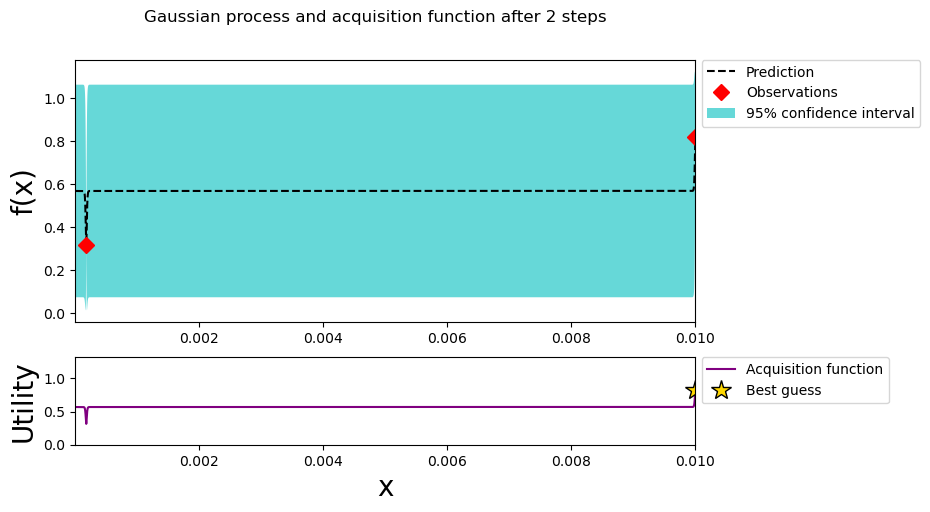

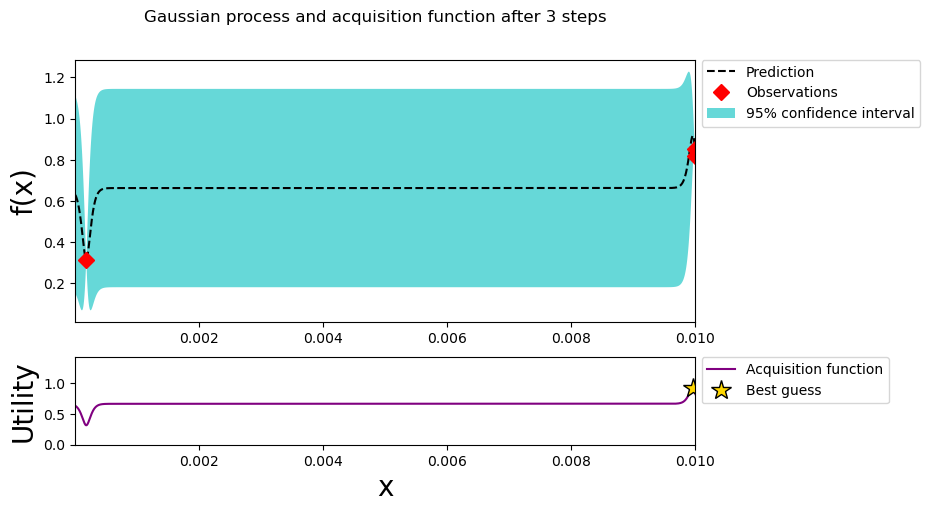

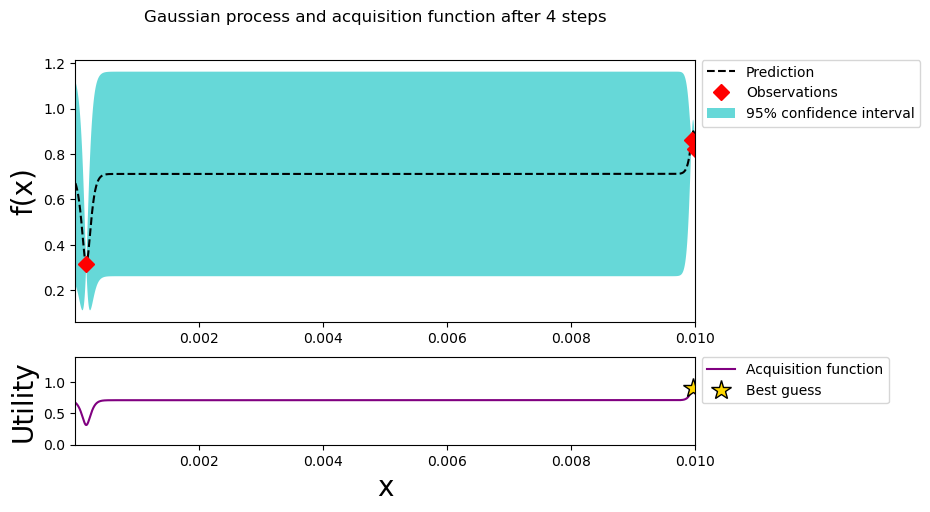

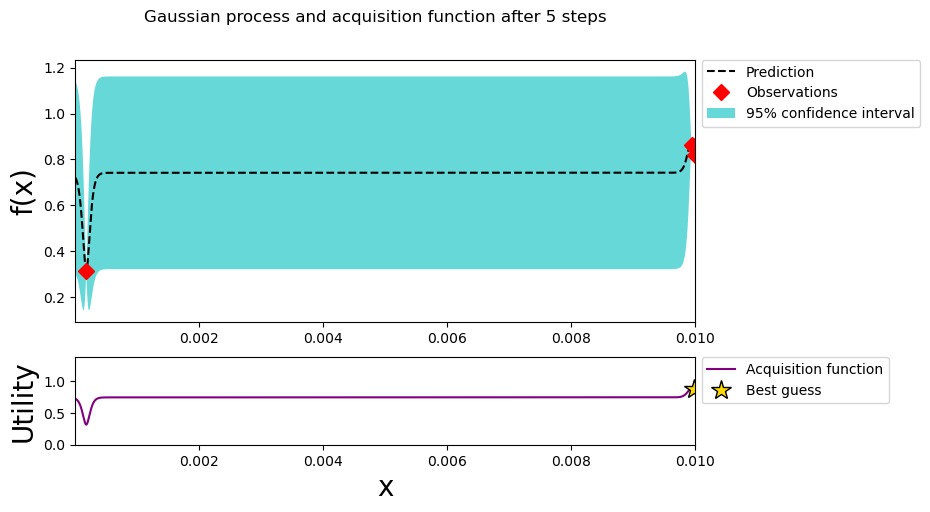

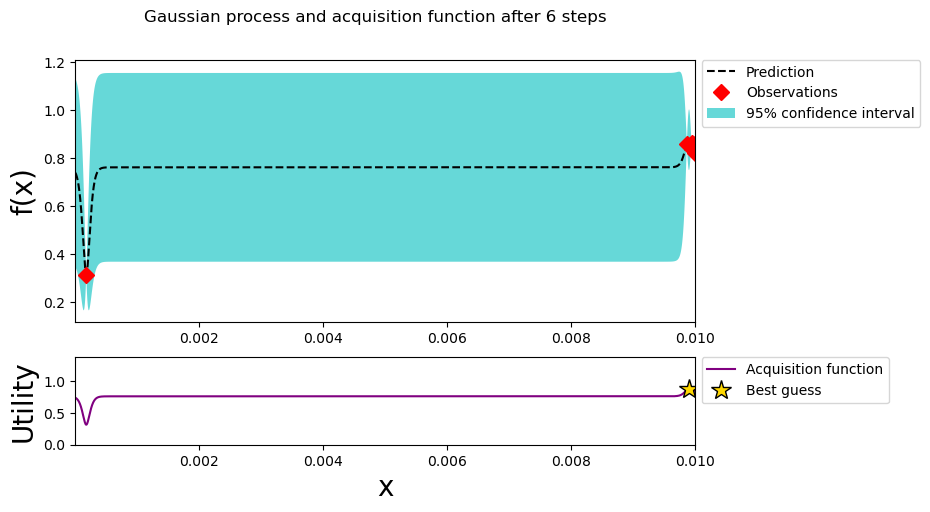

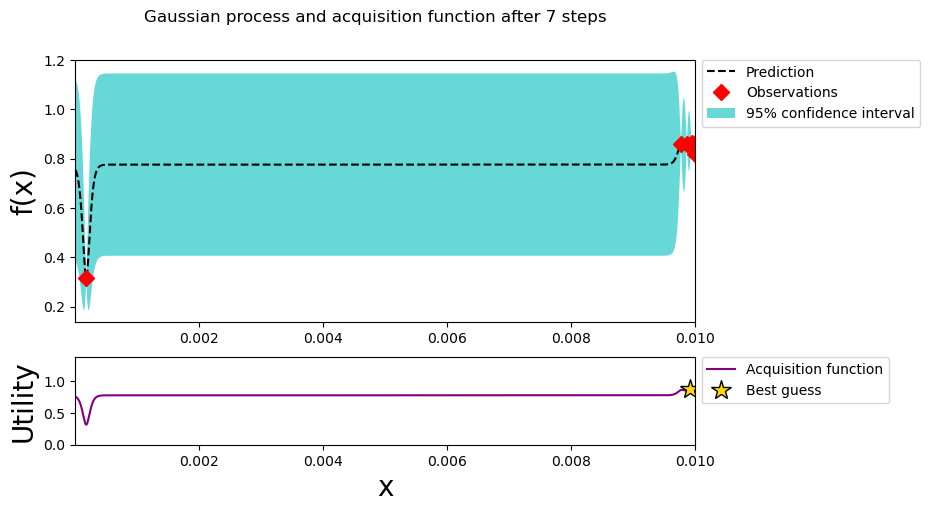

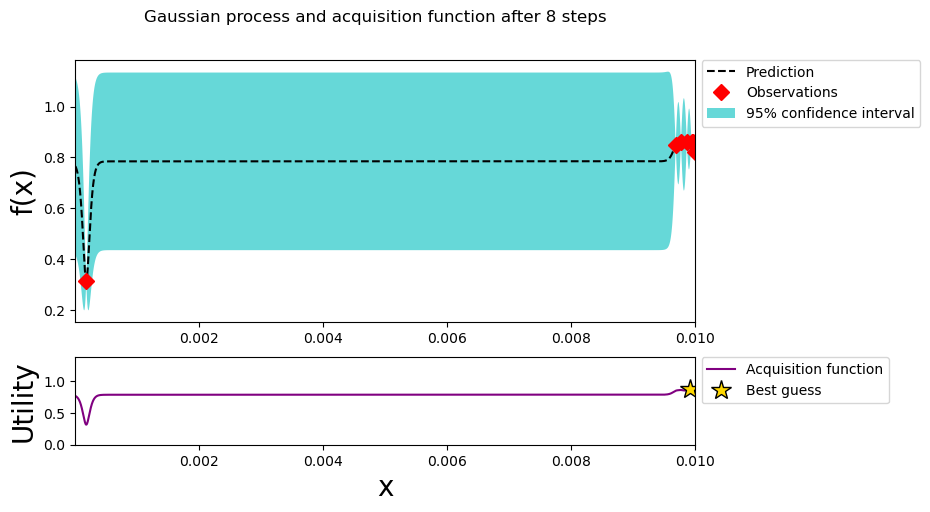

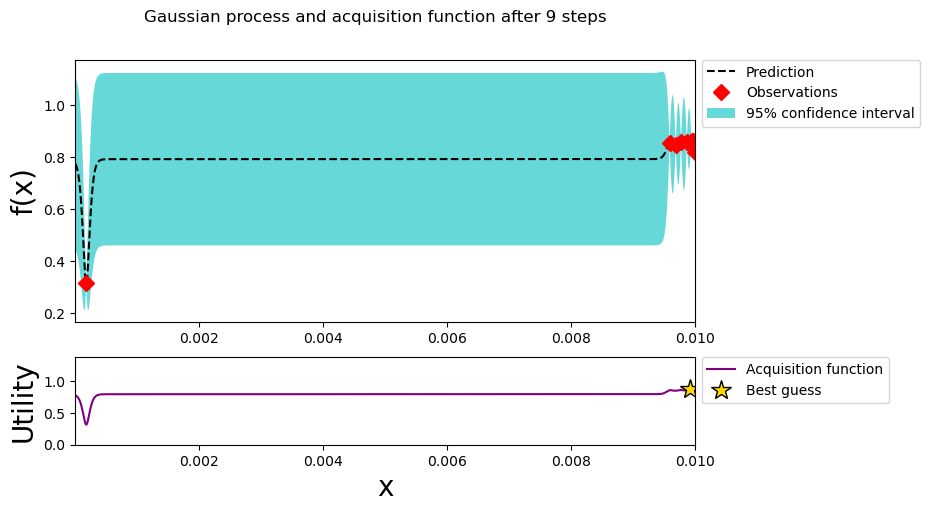

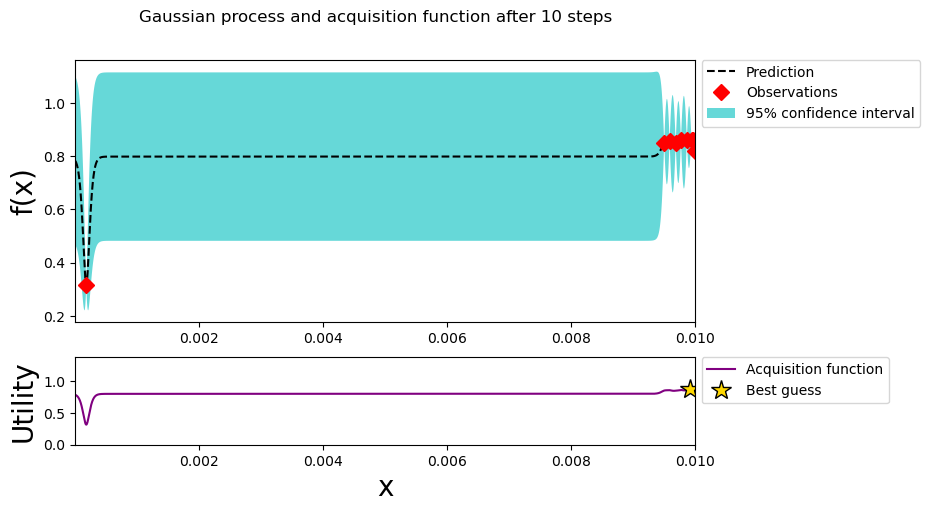

In [ ]:
random.seed(48)
np.random.seed(48)

for i in range(optimization_budget):
    next_point = optimizer.suggest(acq_function)

    target = train_loop(model = ResNet().cuda(),
                        epochs = epochs,
                        **next_point)
    
    optimizer.register(params=next_point, target=target)

    if i > 0:
      plot_gp(optimizer)
    
    print(f"Iteration {i+1}: next point to probe is: {next_point['x']}, corresponded test score is: {target}") 
print('Best point:', optimizer.max)

### Bayesian Optimization (from scratch)

In [8]:
random.seed(48)
np.random.seed(48)

optimization_budget = 10
epochs = 1 # total ResNet training
bounds = {'x': (1e-9, 1e-2)} # Bounded region of parameter space

n_init_samples = 1 # for warming reasons :)
n_random_points = 10000

x_samples = np.random.uniform(bounds['x'][0], bounds['x'][1], size=(n_init_samples, 1)) 

y_samples = np.array([train_loop(model = ResNet().cuda(),
                                 epochs = epochs,
                                 x = x[0]) 
                      for x in x_samples],
)

gp = GaussianProcessRegressor(kernel=Matern(nu=2.5)) # most common kernel

def acq_function(x): # acquisition function
    mu, sigma = gp.predict(x, return_std=True)
    y_best = np.max(y_samples)
    improvement = mu - y_best
    with np.errstate(divide='warn'):
        z = improvement / sigma # zero division warning possible
        ei = improvement * sps.norm.cdf(z) + sigma * sps.norm.pdf(z) 
        ei[sigma == 0.0] == 0.0 
    return ei

Epoch 1
-------------------------------
loss:2.748128 [    0/60000]
loss:2.535519 [ 3000/60000]
loss:2.695111 [ 6000/60000]
loss:2.216364 [ 9000/60000]
loss:2.596105 [12000/60000]
loss:2.494997 [15000/60000]
loss:2.387800 [18000/60000]
loss:2.598637 [21000/60000]
loss:2.306359 [24000/60000]
loss:2.278474 [27000/60000]
loss:2.427963 [30000/60000]
loss:2.442603 [33000/60000]
loss:2.181343 [36000/60000]
loss:2.138866 [39000/60000]
loss:2.001652 [42000/60000]
loss:1.966571 [45000/60000]
loss:2.208072 [48000/60000]
loss:1.986745 [51000/60000]
loss:2.012091 [54000/60000]
loss:2.218518 [57000/60000]
Train error: 
 accuracy: 28.4%, avg loss: 1.965130
Test error: 
 accuracy: 28.6%, avg loss: 1.971381


Iteration 1: next point to probe is: 0.009999940507695785, acquisition value is: 0.005048307413227866
Epoch 1
-------------------------------
loss:3.015660 [    0/60000]
loss:1.934580 [ 3000/60000]
loss:0.895500 [ 6000/60000]
loss:0.761034 [ 9000/60000]
loss:0.567058 [12000/60000]
loss:0.811207 [15000/60000]
loss:0.567209 [18000/60000]
loss:0.326034 [21000/60000]
loss:0.591993 [24000/60000]
loss:0.217811 [27000/60000]
loss:0.526560 [30000/60000]
loss:0.367492 [33000/60000]
loss:0.324945 [36000/60000]
loss:0.389821 [39000/60000]
loss:0.488669 [42000/60000]
loss:0.247038 [45000/60000]
loss:0.345642 [48000/60000]
loss:0.193660 [51000/60000]
loss:0.459963 [54000/60000]
loss:0.192906 [57000/60000]
Train error: 
 accuracy: 86.6%, avg loss: 0.376931
Test error: 
 accuracy: 85.5%, avg loss: 0.417059
Iteration 2: next point to probe is: 0.00999176856627228, acquisition value is: 0.17697140221382857
Epoch 1
-------------------------------
loss:3.001983 [    0/60000]
loss:0.979411 [ 3000/60000]
l

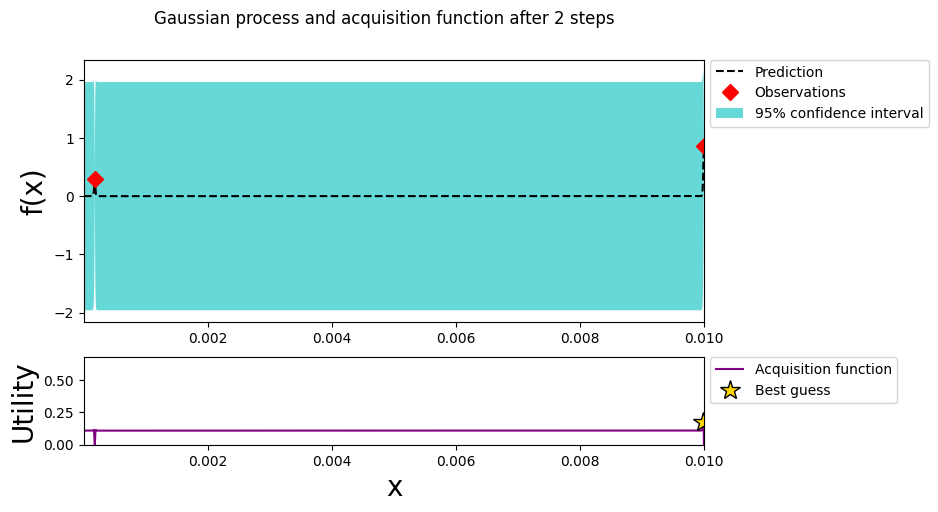

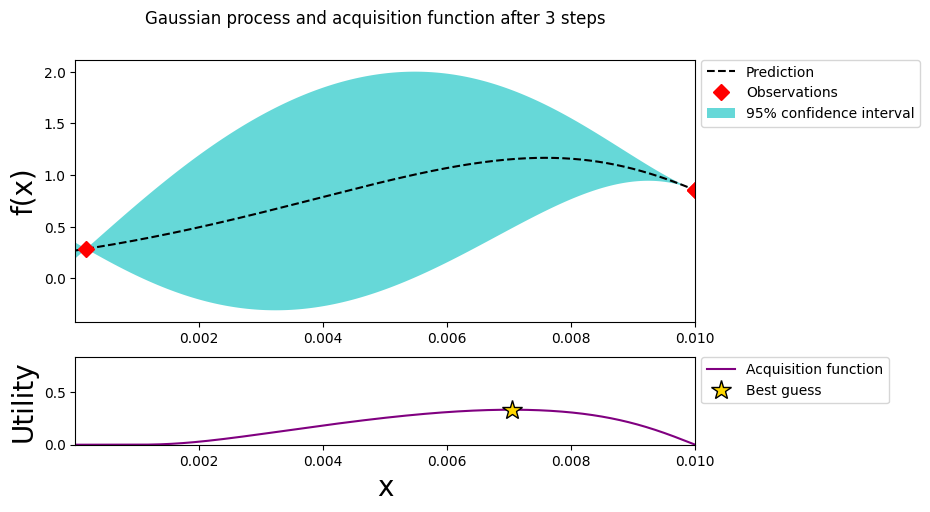

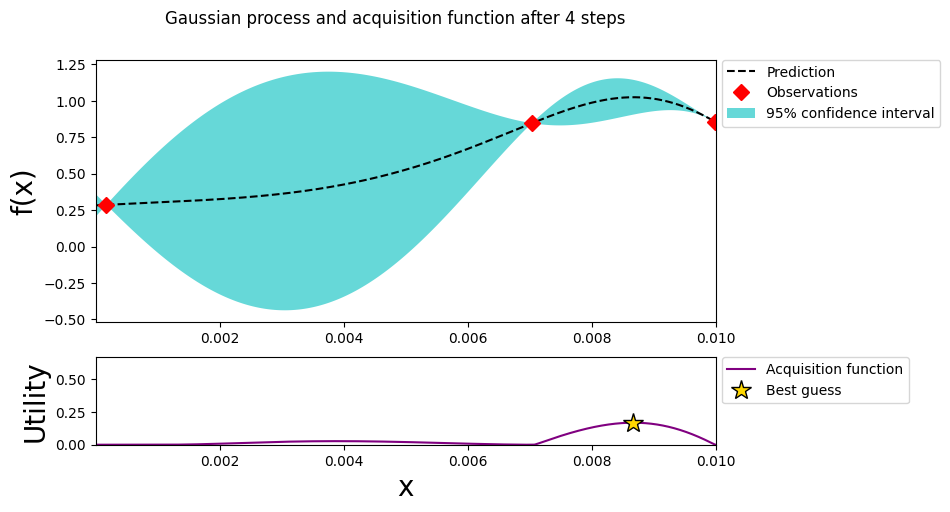

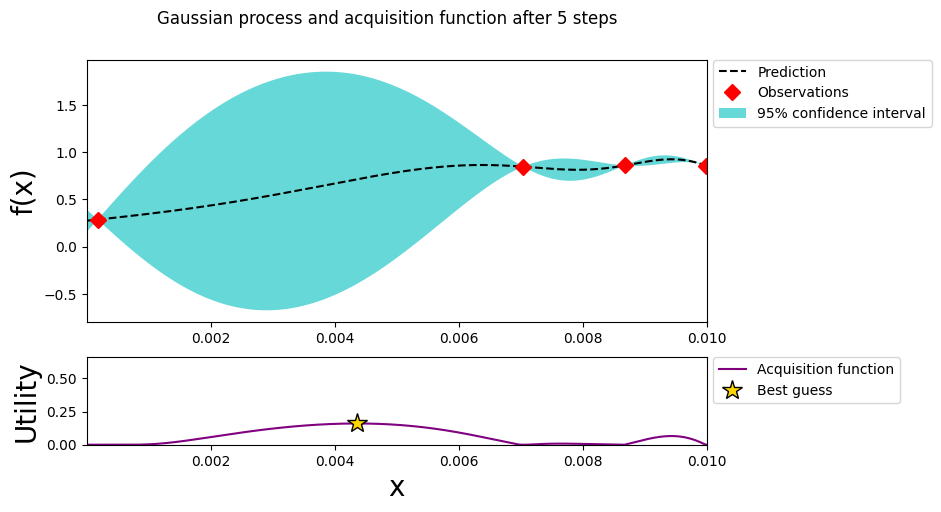

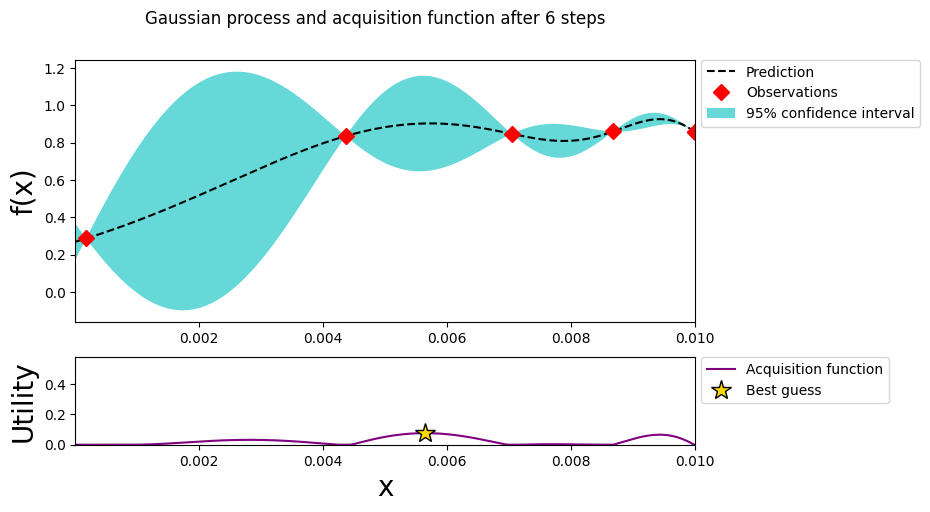

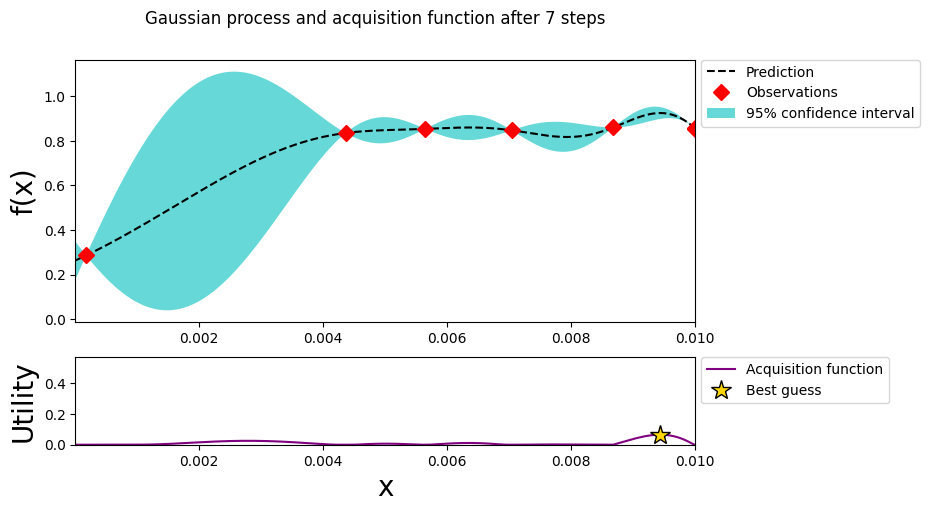

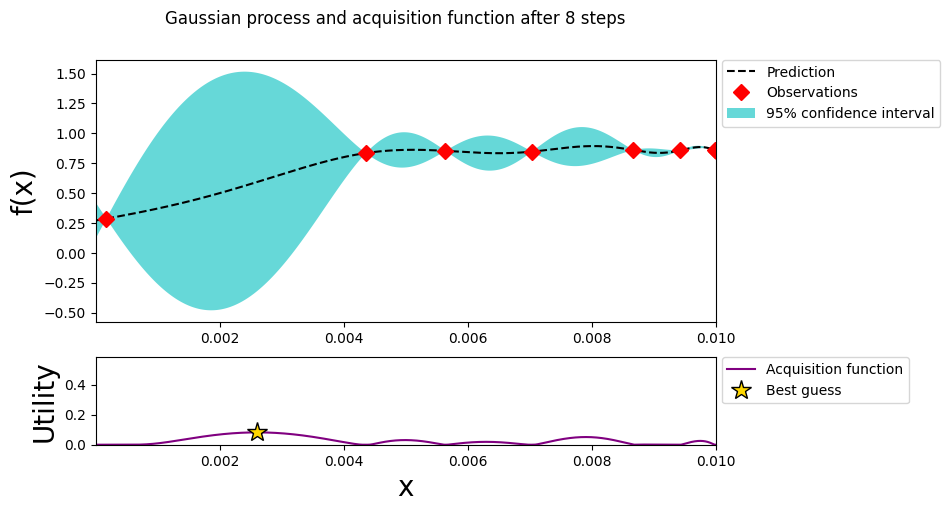

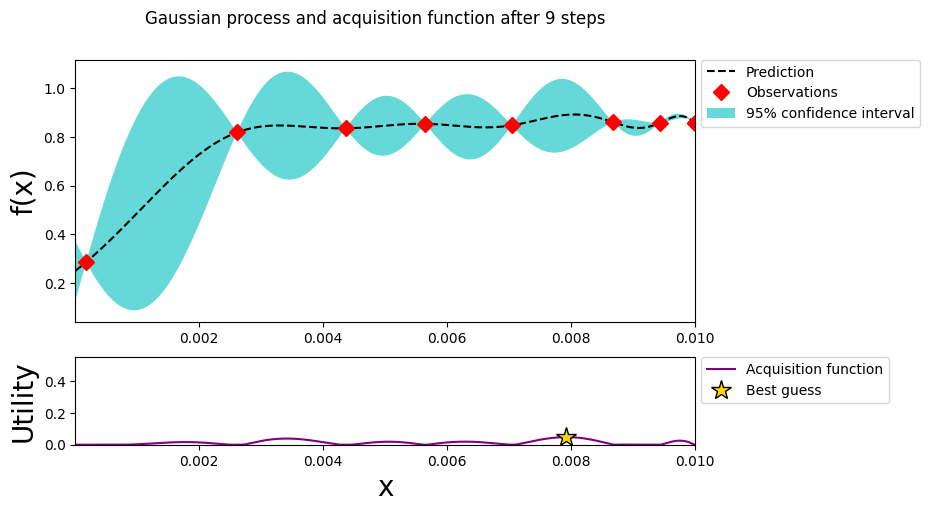

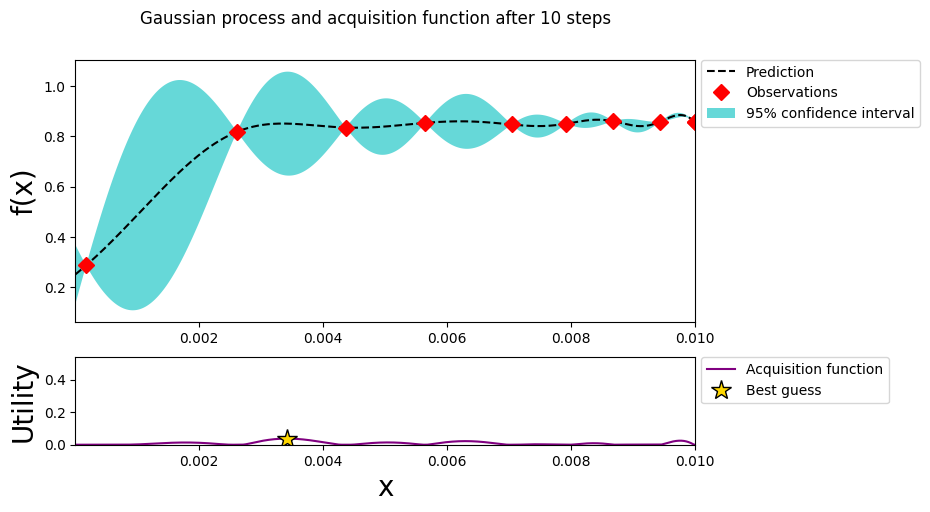

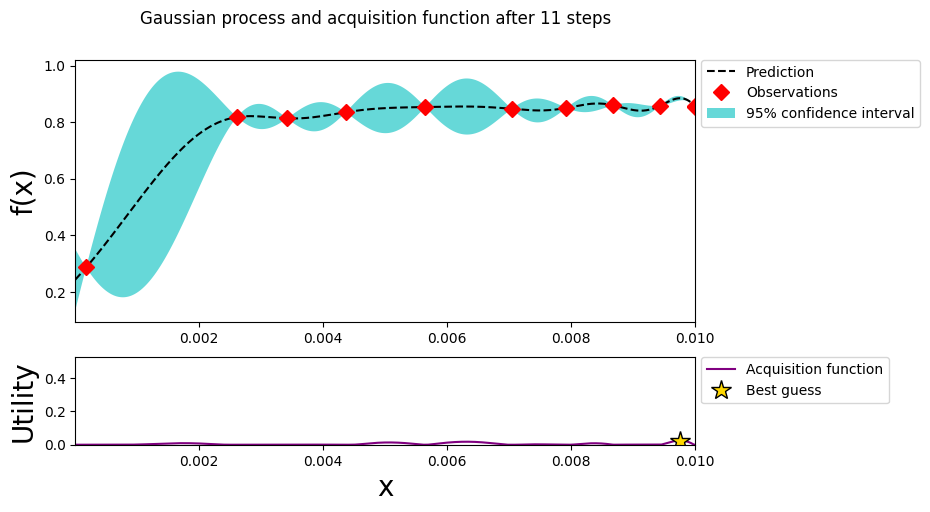

In [9]:
for i in range(optimization_budget-1): 
    # Update Gaussian process with existing samples 
    gp.fit(x_samples, y_samples) 

    # Find the next sample by optimizing acquisition function  
    x_next = None  
    best_acq_value = -np.inf  

    # Sample a number of random points from the parameter space
    x_random_points = np.random.uniform(bounds['x'][0], bounds['x'][1], size=(n_random_points, 1))

    # Evaluate acquisition function at each point and find the maximum  
    acq_values = np.array([acq_function(x.reshape(1,-1)) for x in x_random_points])  
    max_acq_index = np.argmax(acq_values)  
    max_acq_value = acq_values[max_acq_index]  

    if max_acq_value > best_acq_value:  
        best_acq_value = max_acq_value  
        x_next = x_random_points[max_acq_index]  

    print(f"Iteration {i+1}: next point to probe is: {x_next[0]}, acquisition value is: {best_acq_value[0]}")  

    # Evaluate objective function at next sample and add it to existing samples  
    y_next = train_loop(model = ResNet().cuda(),
                        epochs = 1,
                        x = x_next[0])
    x_samples = np.vstack((x_samples, x_next))  
    y_samples = np.append(y_samples, y_next)

    plot_gp_(gp, x_samples, y_samples, acq_function)

# Print final results   
best_index = np.argmax(y_samples)   
best_x = x_samples[best_index]   
best_y = y_samples[best_index]   

print(f"Best point: {best_x[0]}, corresponded test score is: {best_y}")